In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder 
from preprocessor import preprocess

In [2]:
dataframe = pd.read_csv('./dataset/Text_Emotion.csv')

In [3]:
dataframe.head()

,text,emotion
0,carefully word blog posts amount criticism hea...,☹️
1,cannot remember little mermaid feeling carefre...,🙂
2,not feeling super well turns cold knocked next...,🙂
3,feel honored part group amazing talents,🙂
4,think helping also began feel pretty lonely lo...,☹️


In [4]:
dataframe.shape

(282822, 2)

In [5]:
label_enc = LabelEncoder()

In [6]:
dataframe['emotion'] = label_enc.fit_transform(dataframe['emotion'])

In [7]:
dataframe.head()

,text,emotion
0,carefully word blog posts amount criticism hea...,0
1,cannot remember little mermaid feeling carefre...,1
2,not feeling super well turns cold knocked next...,1
3,feel honored part group amazing talents,1
4,think helping also began feel pretty lonely lo...,0


<Axes: >

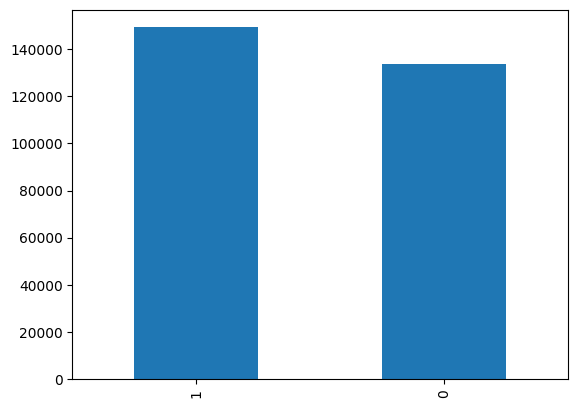

In [8]:
dataframe['emotion'].value_counts().plot(kind='bar')

In [9]:
dataframe.isna().any()

text       False
emotion    False
dtype: bool

Creating DataLoaders

In [10]:
import torch 
from torch.utils.data import DataLoader, Dataset

In [11]:
class TextDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y =Y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return (
            self.X[index],
            torch.tensor(self.Y[index], dtype=torch.int64),
        )

In [12]:
X = dataframe['text']
Y = dataframe['emotion']

In [13]:
dataset = TextDataset(X,Y)

In [14]:
dataset

In [15]:
train_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [16]:
dataiter = iter(train_loader)
next(dataiter)

[('not feeling homesick knowing getting together enjoy mums cooking make want teleporter',),
 tensor([0])]

In [17]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text):
        embedded = self.embedding(text)
        return self.fc(embedded)

In [18]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [19]:
tokenizer = get_tokenizer('basic_english')

In [20]:
def yield_tokens(data_iter):
    for text,_ in data_iter:
        yield tokenizer(text[0])

In [21]:
vocab = build_vocab_from_iterator(yield_tokens(dataiter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [22]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [23]:
text_pipeline('here is the an example')


[0, 0, 4249, 0, 1706]

In [24]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list, text_list, offsets

In [25]:
train_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_batch)

In [26]:
vocab_size = len(vocab)
emsize = 64
model = TextClassificationModel(vocab_size, emsize, 2)

In [27]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [28]:
import time

In [29]:
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for epoch in range(5):
        for idx, (text, label) in enumerate(dataloader):
            optimizer.zero_grad()
            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
            if idx % log_interval == 0 and idx > 0:
                elapsed = time.time() - start_time
                print('| epoch {:3d} | {:5d}/{:5d} batches '
                    '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                                total_acc/total_count))
                total_acc, total_count = 0, 0
                start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [30]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
# Hyperparameters
BATCH_SIZE = 64 # batch size for training

total_accu = None
train_iter = dataiter
train_dataset = to_map_style_dataset(train_iter)
num_train = int(len(train_dataset) * 0.95)

train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)

train(train_dataloader)
    

ValueError: invalid literal for int() with base 10: 'not know feel thing sweet'